# Домашнее задание 2 (30  pts)

## Сжатие полносвязных слоёв в нейросети

В этой задаче вам предлагается исследовать, как изменится точность предсказания нейросети, которая классифицирует изображения, если вместо полносвязных слоёв использовать их сжатое представление, полученное с помощью SVD. Результатом решения этой задачи должен быть график зависимости точности классификации на тестовой выборке от количества параметров нейронной сети.

#### Сначала скачаем данные CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./cifar-10-python.tar.gz to ./


#### Посмотрим, как выглядят изображения

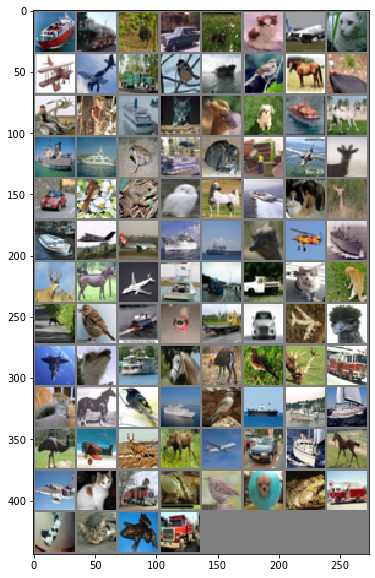

 ship truck  bird   car   cat   cat plane   cat


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Архитектура нейронной сети

Для простоты и демонстрации принципа сжатия слоёв нейронных сетей рассмотрим архитектуру, состоящую только из полносвязных слоёв (то есть линейных преобразований) и стандартных ReLU-нелинейностей. Опять же для наглядности выбрали размерность 1000 для полносвязных слоёв. 

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)

        y = self.fc2(x)
        y = self.ReLU(y)
        y = self.fc3(y)

        x1 = self.ReLU(y + x)

        
        y1 = self.fc4(x1)
        y1 = self.ReLU(y1)
        y1 = self.fc5(y1)

        x2 = self.ReLU(x1 + y1)

        z = self.fc6(x2)
        return F.log_softmax(z, dim=1)

#### Функции для обучения и тестирования результата после каждого прохождения всех данных 

In [4]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [5]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Зададим параметры обучения и вывода промежуточных результатов

In [6]:
log_interval = 50
epochs = 7

### Запускаем обучение с помощью метода оптимизации [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) 
Если у вас не очень мощный ноутбук, то придётся подождать некоторое время. 

In [7]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.326906
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.712035
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.771165
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.648469
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.657723
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.614536
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.586024
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.706003
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.485738
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.476357

Test set: Average loss: 1.4681, Accuracy: 4810/10000 (48%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.561964
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.400630
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.323638
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.442348
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.412035
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.360096
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.275486
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.316674
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.361426
T

- (3 pts) Вычислите SVD для матрицы $1000 \times 1000$, которая соответствует любому слою подходящего размера обученной нейросети. Покажите на графике убывание сингулярных чисел. Какой вывод можно сделать?
- (12 pts) Создайте модель (аналогично классу ```Net```), которая на вход будет принимать экземпляр класса ```Net```, ранг $r > 0$ и список индексов слоёв, веса которых будут сжиматься. Эта модель должна сжимать некоторые полносвязные слои (индексы которых переданы на вход) с помощью SVD разложения, из которого берутся только первые $r$ компонент. Также функция ```forward``` должна быть эффективно реализована с использованием сжатого представления полносвязных слоёв, а в остальном полностью повторять эту же функцию для несжатой обученной сети.
- (5 pts) Постройте зависимость точности предсказания на тестовой выборе от количества параметров, которое необходимо для этого. Это количество, очевидно, некоторым образом зависит от заданного ранга сжатия $r$. Также постройте зависимость времени вычисления от ранга сжатия. Объясните полученные результаты. Для вычисления времени используйте [%timeit](https://docs.python.org/3.6/library/timeit.html) c необходимыми параметрами (примеры смотрите в лекции) 

In [ ]:
# Your solution is here

### Fine-tuning

- (10 pts) Поскольку в вашей модели, которая использует сжатое представление линейных слоёв, параметрами являются матрицы, полученные из SVD соответствующих линейных слоёв, то их также можно оптимизировать. Эта процедура называется fine-tuning. Предлагается провести обучение этих матриц в течение нескольких эпох (от 1 до 5 будет достаточно) и сравнить насколько выросло качество по сравнению с первоначальными значениями. Покажите значения точности на тестовой выборки и объясните полученные результаты.

In [ ]:
# Your solution is here